# Notebook for tuning, training, and testing a LightGBM based forecasting model for the BEICO park
- We are forecasting the minimum produced power in hourly intervals for 48-hours ahead
- We are also getting the P90(0.1 quantile) of the forecasted minimum produced power

In [1]:
import sys
sys.path.insert(0,'../')
from modules.preprocessing import *
from modules.io import *
from modules.learning import *
from modules.patterns import *
from modules.statistics import *
from modules.plots import *
from matplotlib import pyplot as plt
from timeit import default_timer as timer
plt.style.use('ggplot')
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from tqdm.notebook import tqdm
import pandas as pd

# Load and apply filters

We load the data from the BEICO park that we have already resampled in hourly granularity and combined in one file. We also split the index of the data in train and testing for later usage.



In [2]:
df = pd.read_csv("full_park_data_labels_vs2.csv", index_col=0)
df.index = pd.to_datetime(df.index)

# Use data after June of 2021 as instructed
df = filter_dates(df, "2021-07-01", "2022-08-01")

train_index, test_index = df.loc[:"2022-07-01"].index, df.loc["2022-07-01":].index
df = df[[col for col in df.columns if 'Rtr' not in col]]
# df = df[['Grd_Prod_Pwr', 'Amb_WindSpeed_avg', 'MeanWindSpeedUID_10.0m', 'MeanWindSpeedUID_100.0m', 'DirectionUID_100.0m', 'label']]

## Scale the numerical values of the dataset into the [0-1] range

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df.loc[train_index])
turbine_labels = df['label']


df = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
df['label'] = turbine_labels


In [4]:
df.head()

,Grd_Prod_Pwr_avg,Amb_Temp_avg,Amb_WindSpeed_avg,Grd_Prod_Pwr_min,Amb_Temp_min,Amb_WindSpeed_min,Grd_Prod_Pwr_max,Amb_Temp_max,Amb_WindSpeed_max,Grd_Prod_Pwr_std,Amb_WindSpeed_std,Amb_WindDir_Abs_avg,label,MeanWindSpeedUID_10.0m,DirectionUID_10.0m,MeanWindSpeedUID_100.0m,DirectionUID_100.0m
2021-07-01,0.130814,0.521505,0.171381,0.111793,0.516129,0.041096,0.320347,0.516129,0.176015,0.132715,0.061538,0.851359,2,0.212789,0.874687,0.209054,0.878022
2021-07-01,0.150290,0.516129,0.178591,0.111680,0.516129,0.044521,0.306674,0.516129,0.176015,0.144663,0.061538,0.857781,3,0.212789,0.874687,0.209054,0.878022
2021-07-01,0.155777,0.543011,0.187465,0.110906,0.516129,0.075342,0.309908,0.516129,0.185687,0.125105,0.054808,0.874442,4,0.212789,0.874687,0.209054,0.878022
2021-07-01,0.144565,0.537634,0.229063,0.111612,0.516129,0.065068,0.367835,0.516129,0.199226,0.141141,0.071154,0.884819,5,0.212789,0.874687,0.209054,0.878022
2021-07-01,0.141649,0.537634,0.178591,0.111088,0.516129,0.078767,0.326012,0.516129,0.206963,0.138865,0.065385,0.839073,6,0.212789,0.874687,0.209054,0.878022


In [5]:
df.describe()

,Grd_Prod_Pwr_avg,Amb_Temp_avg,Amb_WindSpeed_avg,Grd_Prod_Pwr_min,Amb_Temp_min,Amb_WindSpeed_min,Grd_Prod_Pwr_max,Amb_Temp_max,Amb_WindSpeed_max,Grd_Prod_Pwr_std,Amb_WindSpeed_std,Amb_WindDir_Abs_avg,label,MeanWindSpeedUID_10.0m,DirectionUID_10.0m,MeanWindSpeedUID_100.0m,DirectionUID_100.0m
count,94389.000000,94389.000000,94389.000000,94389.000000,94389.000000,94389.000000,94389.000000,94389.000000,94389.000000,94389.000000,94389.000000,94389.000000,95010.000000,95010.000000,95010.000000,95010.000000,95010.000000
mean,0.273734,0.487503,0.217412,0.223157,0.466210,0.137196,0.381567,0.476274,0.178228,0.129797,0.040601,0.507632,6.500000,0.241222,0.514592,0.256281,0.521772
std,0.283608,0.181209,0.102180,0.170778,0.181641,0.076874,0.329955,0.181905,0.085362,0.132519,0.025300,0.262504,2.872296,0.125199,0.272020,0.128280,0.271691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.047141,0.344086,0.149196,0.107813,0.322581,0.078767,0.085187,0.322581,0.117988,0.026827,0.024038,0.278853,4.000000,0.148307,0.268130,0.162311,0.275910
50%,0.172128,0.510753,0.205214,0.161833,0.483871,0.136986,0.275464,0.483871,0.164410,0.076809,0.035577,0.563757,6.500000,0.225685,0.574048,0.244755,0.585440
75%,0.404024,0.634409,0.270105,0.271807,0.612903,0.181507,0.680695,0.612903,0.220503,0.202858,0.051923,0.698017,9.000000,0.309511,0.707419,0.327567,0.715754
max,1.000000,1.370968,1.000000,1.000000,1.354839,1.000000,1.000000,1.354839,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000


## Clean some values of power by using a simple filter and IQR outlier detection method. The data manipulation is performed only on the training part of each turbine independantly 

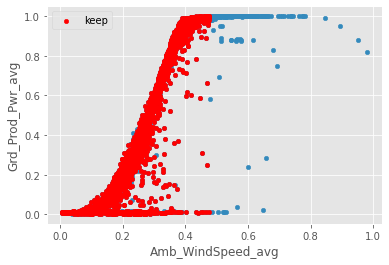

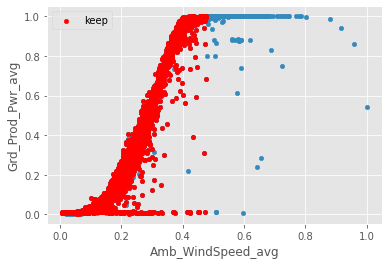

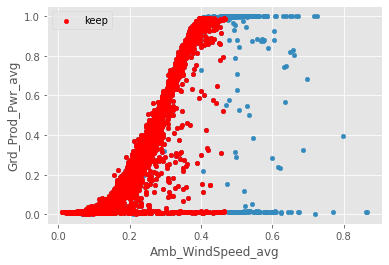

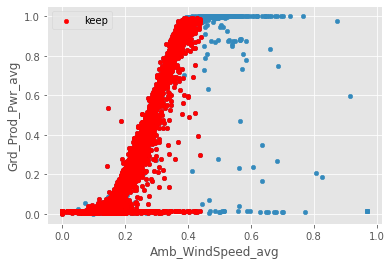

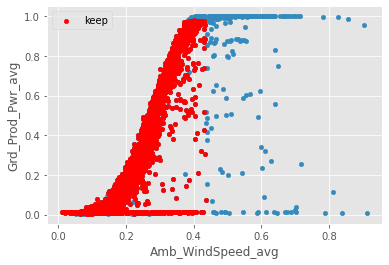

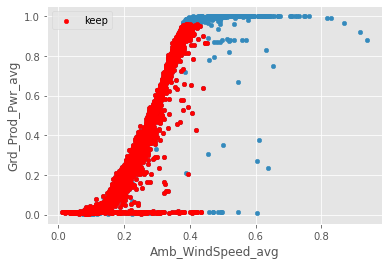

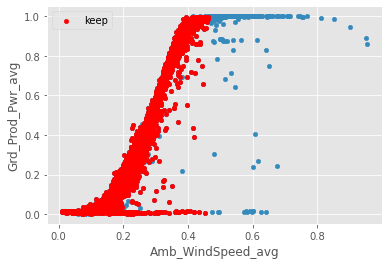

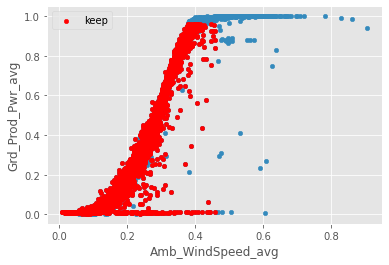

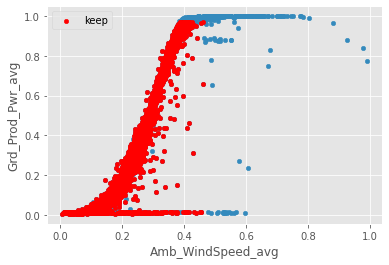

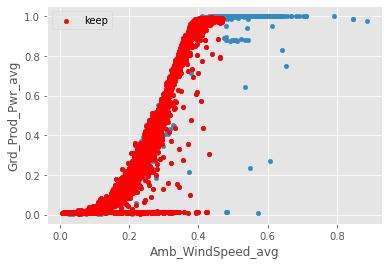

In [6]:
df_outliers=df.copy()
for l in np.unique(df.label):
    l = int(l)
    df_label = df[df.label==l].copy()

    # # clean misleading power
    
#     df_label.loc[(df_label.index.isin(train_index)) 
#                   & ((df_label['Grd_Prod_Pwr_avg']<0.02)
#                   & (df_label['Amb_WindSpeed_avg']>0.13)), 
#                   ['Grd_Prod_Pwr_avg', 'Grd_Prod_Pwr_min',
#                    'Grd_Prod_Pwr_max', 'Grd_Prod_Pwr_std']]=np.nan
    
    df_iqr = outliers_IQR(df_label.loc[df_label.index.isin(train_index)][['Grd_Prod_Pwr_avg', 'Amb_WindSpeed_avg']])
    df_label.loc[(~df_label.index.isin(df_iqr.index)) 
                 & (df_label.index.isin(train_index)),
                  ['Grd_Prod_Pwr_avg', 'Grd_Prod_Pwr_min',
                   'Grd_Prod_Pwr_max', 'Grd_Prod_Pwr_std']]=np.nan
    
    df_label = np.clip(df_label, 0, 1)
    df_label['label'] = l
    ax = df_outliers.loc[df_outliers.label==l].plot.scatter(x='Amb_WindSpeed_avg', y='Grd_Prod_Pwr_avg')
    df_label.loc[df_label.index.isin(train_index)].plot.scatter(x='Amb_WindSpeed_avg', y='Grd_Prod_Pwr_avg', color='r', alpha=1, ax=ax, label='keep')
    plt.legend()
    df.loc[df.label==l]=df_label

## We use sklearn's IterativeImputer to impute any the nan values in the dataset. IterativeImputer is fitted only on the training set and the fitted instance is used to impute values in the test set.

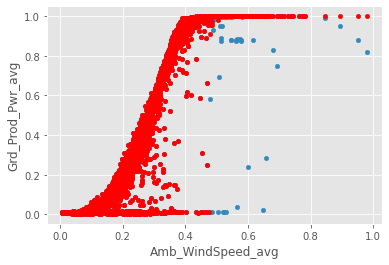

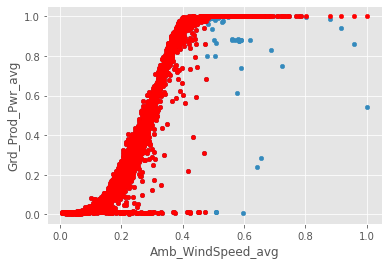

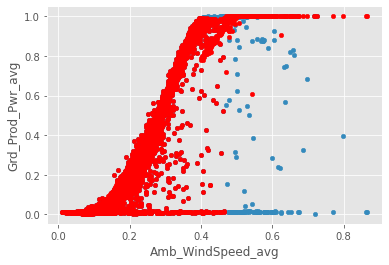

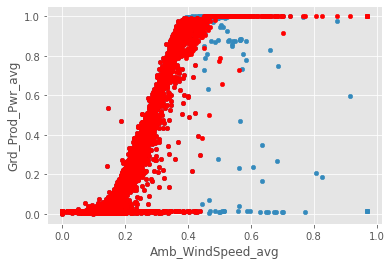

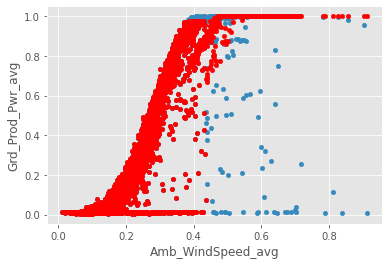

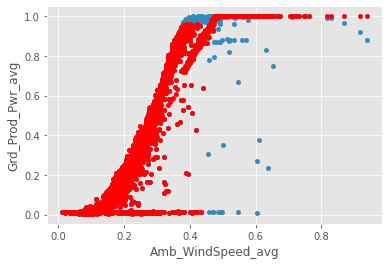

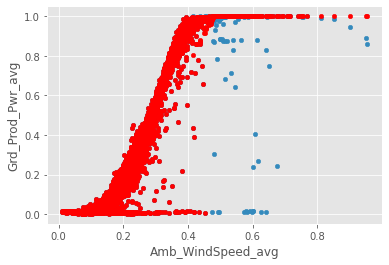

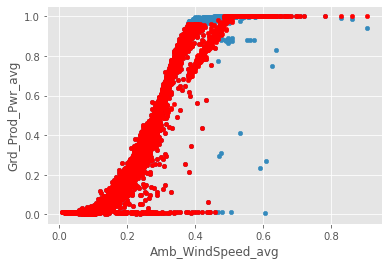

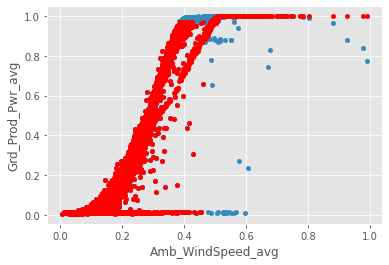

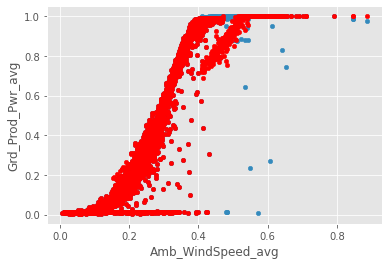

In [7]:
# fill remaining missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(random_state=42, max_iter=50, skip_complete=True, tol=1e-2, 
                            verbose=0, imputation_order='ascending', initial_strategy='mean',
                            n_nearest_features=None)

for l in np.unique(df.label):
    l = int(l)
    df_label = df[df.label==l].copy()
    imp_mean.fit(df_label.loc[df_label.index.isin(train_index)].values)
    df_label = pd.DataFrame(np.clip(imp_mean.transform(df_label.values), 0, 1), columns=df_label.columns, index=df_label.index)
    df_label.label = l
    df.loc[df.label==l]=df_label
    
for l in np.unique(df.label):
    l = int(l)
    ax = df_outliers[df_outliers.label==l].plot.scatter(x='Amb_WindSpeed_avg', y='Grd_Prod_Pwr_avg')
    df[df.label==l].plot.scatter(x='Amb_WindSpeed_avg', y='Grd_Prod_Pwr_avg', ax=ax, color='r')
    plt.show()

In [8]:
print(df.shape)

(95010, 17)


In [9]:
df_stops = pd.read_csv('stops/stops_per_turbine.csv', index_col=0, converters={'stop_times': pd.eval})
df_stops.index = df_stops.index.map(lambda x: int(x.replace('WT', "")))
df_stops

df_list = []

for l in np.unique(df.label):
    df_temp = df[df.label==l].copy()
    stop_index = pd.Index(df_stops.loc[l, 'stop_times'])
    df_temp.loc[df_temp.index.isin(stop_index), 'Grd_Prod_Pwr_min'] = np.nan
#     df_temp.loc[df_temp.index.isin(stop_index.intersection(train_index)), 'Grd_Prod_Pwr_min'] = np.nan # only in test set
    df_list.append(df_temp)
    
df = pd.concat(df_list, axis=0)

## Here we create some lagged features and also some time based features

In [10]:
from feature_engine.datetime import DatetimeFeatures

lags = 3
df_list = []

for l in np.unique(df.label):
#     lag_f = LagFeatures(periods=[1, 2, 3])
#     df_temp = lag_f.fit_transform(df.loc[df.label==l])

#     df_temp = df_temp.dropna()
    df_lags_list = [df.loc[df.label==l]]
    df_temp = df.loc[df.label==l]
    for i in range(1, lags+1):
        df_temp = df_temp.shift(i)
        df_temp.columns = [c+f"_lag_{i}" for c in df_temp.columns]
        df_lags_list.append(df_temp.copy())
        
    df_lagged = pd.concat(df_lags_list, axis=1)
    
    dtfs = DatetimeFeatures(
        variables="index",
        features_to_extract=["month", "hour", "day_of_week"],
        drop_original=False
    )

    df_temp = dtfs.fit_transform(df_lagged.loc[df_lagged.label==l])
    df_list.append(df_temp.copy())

df = pd.concat(df_list, axis=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95010 entries, 2021-07-01 00:00:00 to 2022-08-01 00:00:00
Data columns (total 71 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Grd_Prod_Pwr_avg                           95010 non-null  float64
 1   Amb_Temp_avg                               95010 non-null  float64
 2   Amb_WindSpeed_avg                          95010 non-null  float64
 3   Grd_Prod_Pwr_min                           89356 non-null  float64
 4   Amb_Temp_min                               95010 non-null  float64
 5   Amb_WindSpeed_min                          95010 non-null  float64
 6   Grd_Prod_Pwr_max                           95010 non-null  float64
 7   Amb_Temp_max                               95010 non-null  float64
 8   Amb_WindSpeed_max                          95010 non-null  float64
 9   Grd_Prod_Pwr_std                           95010 non-null  

In [11]:
df.describe()

,Grd_Prod_Pwr_avg,Amb_Temp_avg,Amb_WindSpeed_avg,Grd_Prod_Pwr_min,Amb_Temp_min,Amb_WindSpeed_min,Grd_Prod_Pwr_max,Amb_Temp_max,Amb_WindSpeed_max,Grd_Prod_Pwr_std,...,Amb_WindSpeed_std_lag_1_lag_2_lag_3,Amb_WindDir_Abs_avg_lag_1_lag_2_lag_3,label_lag_1_lag_2_lag_3,MeanWindSpeedUID_10.0m_lag_1_lag_2_lag_3,DirectionUID_10.0m_lag_1_lag_2_lag_3,MeanWindSpeedUID_100.0m_lag_1_lag_2_lag_3,DirectionUID_100.0m_lag_1_lag_2_lag_3,month,hour,day_of_week
count,95010.000000,95010.000000,95010.000000,89356.000000,95010.000000,95010.000000,95010.000000,95010.000000,95010.000000,95010.000000,...,94950.000000,94950.000000,94950.000000,94950.000000,94950.000000,94950.000000,94950.000000,95010.000000,95010.000000,95010.000000
mean,0.275251,0.486950,0.217605,0.220937,0.465746,0.137337,0.386183,0.475714,0.178381,0.144811,...,0.040633,0.508109,6.500000,0.241201,0.514467,0.256258,0.521649,6.564783,11.502158,3.014841
std,0.282230,0.179021,0.102040,0.147031,0.179708,0.076738,0.333711,0.179704,0.085249,0.150654,...,0.025267,0.262097,2.872296,0.125221,0.272058,0.128302,0.271730,3.312361,6.922337,1.999245
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.048295,0.344086,0.149196,0.111657,0.322581,0.078767,0.086793,0.322581,0.117988,0.027997,...,0.024038,0.281320,4.000000,0.148307,0.267852,0.161943,0.275354,4.000000,6.000000,1.000000
50%,0.174467,0.505376,0.205214,0.169317,0.483871,0.136986,0.278915,0.483871,0.164410,0.084563,...,0.035577,0.563896,6.500000,0.225685,0.573770,0.244387,0.585163,7.000000,12.000000,3.000000
75%,0.408387,0.634409,0.270105,0.280405,0.612903,0.181507,0.683538,0.612903,0.220503,0.230464,...,0.051923,0.698111,9.000000,0.309511,0.707419,0.327567,0.715754,9.000000,18.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,12.000000,23.000000,6.000000


## Add the future known values from ERA5, the targets and time based features for the future for in each feature vector

In [12]:
future_steps = 48
df_list = []
for l in np.unique(df.label):
    df_list_inner = [df.loc[df.label==l]]
    df_future = df.loc[df.label==l, ['Grd_Prod_Pwr_min', 'MeanWindSpeedUID_10.0m', 'MeanWindSpeedUID_100.0m', 
                                     'DirectionUID_100.0m', 'DirectionUID_100.0m', "month", "hour", "day_of_week"]]
    for i in range(1, future_steps+1):
        if i != 0:
            df_temp = df_future.shift(-i)
            df_temp.columns = [c+f"_(t+{i})" for c in df_future.columns]
            df_list_inner.append(df_temp) 

    df_f = pd.concat(df_list_inner, axis=1)
    df_f.head()
    df_list.append(df_f)

df_f = pd.concat(df_list, axis=0)

In [13]:
print(df_f.shape)
df_f = df_f.dropna()
print(df_f.shape)

(95010, 455)
(42342, 455)


In [14]:
df_train, df_test = df_f.loc[df_f.index.isin(train_index)], df_f.loc[df_f.index.isin(test_index)]

## We instantiate the regressor object and define possible parameters to try

In [15]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

regression_models = {}

lgbmr = LGBMRegressor(n_jobs=32, deterministic=True)
model = RegressorChain(lgbmr)
parameters = {'regression__base_estimator__learning_rate': list(np.linspace(0.01, 0.3, 10)),
              'regression__base_estimator__extra_trees': [True, False],
              'regression__base_estimator__reg_alpha': [10**x for x in range(-6, 3, 1)],
              'regression__base_estimator__reg_lambda': [10**x for x in range(-6, 3, 1)],
              'regression__base_estimator__max_bin': [31, 63, 127, 255],
              'regression__base_estimator__min_child_samples': [5, 10, 20],
              'regression__base_estimator__num_leaves': [7, 15, 31],
              'regression__base_estimator__subsample': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
              'regression__base_estimator__subsample_freq': [1, 5, 10, 20],
              'regression__base_estimator__colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
              'regression__base_estimator__n_estimators': list(range(100, 1000, 100)),
              'regression__base_estimator__max_depth': list(range(1, 11, 2))}

pipeline = Pipeline([("regression", model)])
regression_models['lgbm_regression'] = (pipeline, parameters)

target_features = [x for x in df_f.columns if 'Grd_Prod_Pwr_min_(t+' in x]
fit_features_test = [x for x in df_f.columns if 'Grd_Prod_Pwr_min_(t+' not in x]
fit_features = fit_features_test

print("Training set")
print(df_train.shape[0])
print(len(list(target_features)))
print(len(list(fit_features_test)))

Training set
40660
48
407


## Perform the Time Series CV to find the optimal parameters for our model

In [16]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
)
scorer = make_scorer(mape1, greater_is_better=False)

In [17]:
hyper_params = {}
# times = {}
# for key, (pipeline, params) in regression_models.items():
#     print(f"Tuning and validating {key}...")
#     print(params.keys())
#     print(pipeline)
#     start = timer()
#     temp = perform_grid_search(df_train, fit_features_test, target_features, scorer, pipeline, params, randomized=True, cv=ts_cv, n_jobs=2, n_iter=250)
#     end = timer()
#     times[key] = end-start
#     print(f'Selected hyper-parameters for {key} \n {temp}')
#     hyper_params[key] = temp
# print(times)
hyper_params['lgbm_regression'] = {'regression__base_estimator__learning_rate': 0.05,
                                   'regression__base_estimator__max_bin': 255,
                                   'regression__base_estimator__min_child_samples': 10, 
                                   'regression__base_estimator__subsample': 0.9,
                                   'regression__base_estimator__subsample_freq': 1, 
                                   'regression__base_estimator__colsample_bytree': 0.9, 
                                   'regression__base_estimator__n_estimators': 500, 
                                   'regression__base_estimator__max_depth': 10}

# Define a naive baseline method that just repeats the last known value 

In [18]:
def naive_baseline(df_test):
       
    preds = []
    for i in range(df_test.shape[0]):
        t = [x for x in df_test.columns if 'Grd_Prod_Pwr_min_(t+' in x]
        pred = np.zeros(len(t))
        pred =  pred + df_test.iloc[i, :]['Grd_Prod_Pwr_min']
        preds.append(pred)
    preds = np.vstack(preds)
    return preds


# Train and Test the forecasting model using the parameters we found earlier

In [19]:
print("Fit with selected parameters and predict on test set")
import lightgbm
from copy import deepcopy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

df_test = df_test
mapes = {}
maes = {}
rmses = {}
for key, (pipeline, _) in regression_models.items():
    chosen_params = hyper_params[key]

    history = df_train
    result = []
    result_l = []
    result_u = []
    train_mapes = []
    print(history.shape)
    temp_pipeline = deepcopy(pipeline)
    temp_pipeline1 = deepcopy(pipeline)
    quantile_params = deepcopy(chosen_params)
    pipeline, y_pred, r_sq, mae_, me, mape_train, mpe = fit_pipeline(history, fit_features, target_features, pipeline, chosen_params)
    quantile_params['regression__base_estimator__objective'] = 'quantile'
    quantile_params['regression__base_estimator__alpha']= 0.1
    pipeline_lower, _, _, _, _, _, _ = fit_pipeline(history, fit_features, target_features, temp_pipeline1, quantile_params)
    print("Training Mape")
    print(mape_train)



all_mapes = []
p_list_pred = []
p_list_pred_lower = []
p_list = []



Fit with selected parameters and predict on test set
(40660, 455)
Training Mape
0.062143816491316194


In [20]:
for l in np.unique(df.label):
    unq_idx = test_index.drop_duplicates()
    temp = np.empty((unq_idx.shape[0], future_steps))
    temp[:] = 1e-6
    result_container = pd.DataFrame(temp.copy(), index=unq_idx)
    y_pred_test = np.clip(pipeline.predict(df_test.loc[df_test.label==l][fit_features].values), 0, 1)
    result_temp = pd.DataFrame(y_pred_test, index=df_test.loc[df_test.label==l].index)
    result_container.loc[result_temp.index] = result_temp

    result_container_lower = pd.DataFrame(temp.copy(), index=unq_idx)
    y_pred_test_lower = np.clip(pipeline_lower.predict(df_test.loc[df_test.label==l][fit_features].values), 0, 1)
    result_temp_lower = pd.DataFrame(y_pred_test_lower, index=df_test.loc[df_test.label==l].index)
    result_container_lower.loc[result_temp_lower.index] = result_temp_lower
    
    
    
    gt_container = pd.DataFrame(temp.copy(), index=unq_idx)
    y_test = df_test.loc[df_test.label==l][target_features]
    gt_temp = pd.DataFrame(y_test, index=df_test.loc[df_test.label==l].index)
    gt_container.loc[gt_temp.index] = gt_temp
    p_list_pred.append(result_container.copy())
    p_list_pred_lower.append(result_container_lower.copy())
    p_list.append(gt_container.copy())
    all_mapes.append(mape1(y_test, y_pred_test))
    

In [22]:
park_mat_pred = np.dstack(p_list_pred)
park_mat_pred_lower = np.dstack(p_list_pred_lower)
park_mat = np.dstack(p_list)
avg_test_preds = np.sum(park_mat_pred, axis=2)
avg_test_preds_lower = np.sum(park_mat_pred_lower, axis=2)
avg_test = np.sum(park_mat, axis=2)
print('Mape on aggregate test set')
print(mape1(avg_test.ravel(), avg_test_preds.ravel()))
mapes['lgbm'] = mape1(avg_test.ravel(), avg_test_preds.ravel())
mae_l = mae(avg_test, avg_test_preds)
rmse_l = np.sqrt(mse(avg_test, avg_test_preds))
maes['lgbm'] = mae_l
rmses['lgbm'] = rmse_l

Mape on aggregate test set
0.09227329810273935


In [23]:
print("Model metrics on test set")
print("MAPE", mape1(avg_test.ravel(), avg_test_preds.ravel()))
print("MAE", mae_l)
print("RMSE", rmse_l)

Model metrics on test set
MAPE 0.09227329810273935
MAE 0.07101530297868337
RMSE 0.15788588970307962


In [24]:
p_baseline_pred = []
for l in np.unique(df.label):
    unq_idx = test_index.drop_duplicates()
    temp = np.empty((unq_idx.shape[0], future_steps))
    temp[:] = 0
    baseline_container = pd.DataFrame(temp.copy(), index=unq_idx)
    p_baseline = naive_baseline(df_test[df_test.label==l])
    baseline_temp = pd.DataFrame(p_baseline, index=df_test.loc[df_test.label==l].index)
    baseline_container.loc[baseline_temp.index] = baseline_temp
    p_baseline_pred.append(baseline_container)
    
park_mat_base_pred = np.dstack(p_baseline_pred)
avg_base_preds = np.sum(park_mat_base_pred, axis=2)

m = mape1(avg_test.ravel(), avg_base_preds.ravel())
mae_b = mae(avg_test, avg_base_preds)
rmse_b = np.sqrt(mse(avg_test, avg_base_preds))
mapes['baseline'] = m
maes['baseline'] = mae_b
rmses['baseline'] = rmse_b
print("Baseline metrics on test set")
print("MAPE", m)
print("MAE", mae_b)
print("RMSE", rmse_b)

Baseline metrics on test set
MAPE 0.18739465281062026
MAE 0.15127686810754545
RMSE 0.35327766907118435


## Visually compare our forecasting model to a naive baseline in the test set

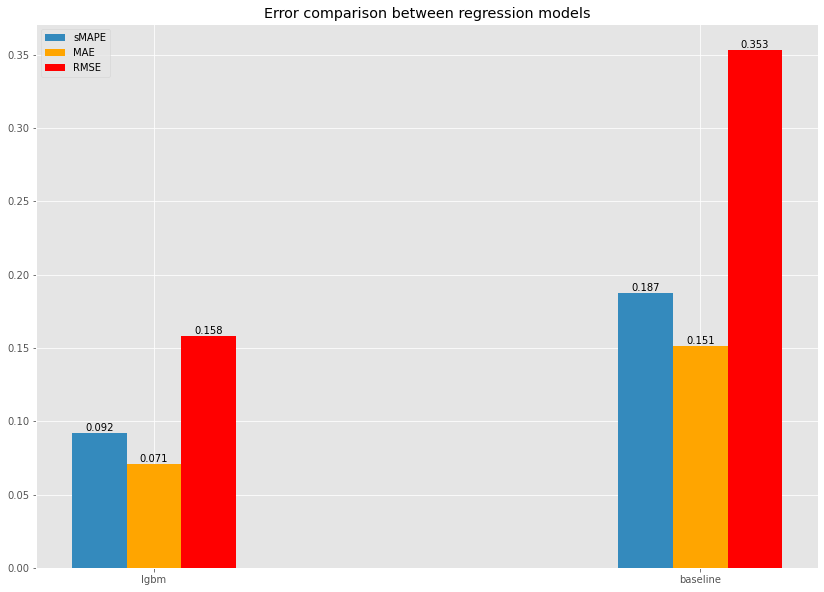

In [25]:
plt.figure(figsize=(14,10))
plt.title('Error comparison between regression models')
x = np.arange(len(mapes.values()))
bars = plt.bar(x-0.1, np.array(list(mapes.values())), width=0.1, color='C1', label='sMAPE')
plt.bar_label(bars, labels=np.round(list(mapes.values()), 3))
bars = plt.bar(x, np.array(list(maes.values())), width=0.1, color='orange', label='MAE')
plt.bar_label(bars, labels=np.round(list(maes.values()), 3))
bars = plt.bar(x+0.1, np.array(list(rmses.values())), width=0.1, color='red', label='RMSE')
plt.bar_label(bars, labels=np.round(list(rmses.values()), 3))
plt.xticks(ticks=np.arange(len(mapes.values())) ,labels=mapes.keys())
plt.legend()
plt.show()

## Calculate the percentage of times the actual minimum power drops below the forecasted P90

In [26]:
def percentage_of_misses(true, predicted):
    ratio = np.sum(true < predicted) / len(true)
    return ratio

In [27]:
pom = percentage_of_misses(avg_test.ravel(), avg_test_preds_lower.ravel())
print(f"Percentage of missses: {pom}")

Percentage of missses: 0.05103467561521253


## Compare the actual min, forecasted min, and P90 min for a set of random 2day segments

(745, 48)
(745,)


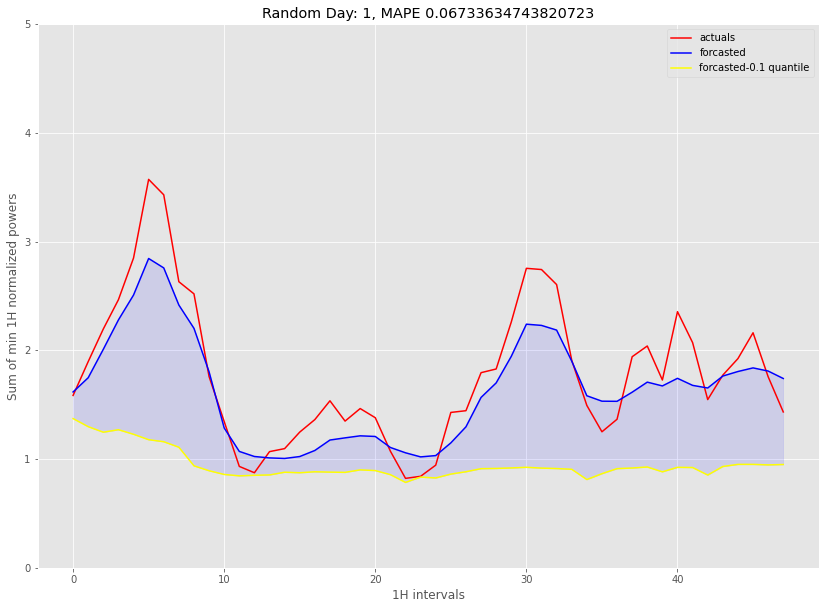

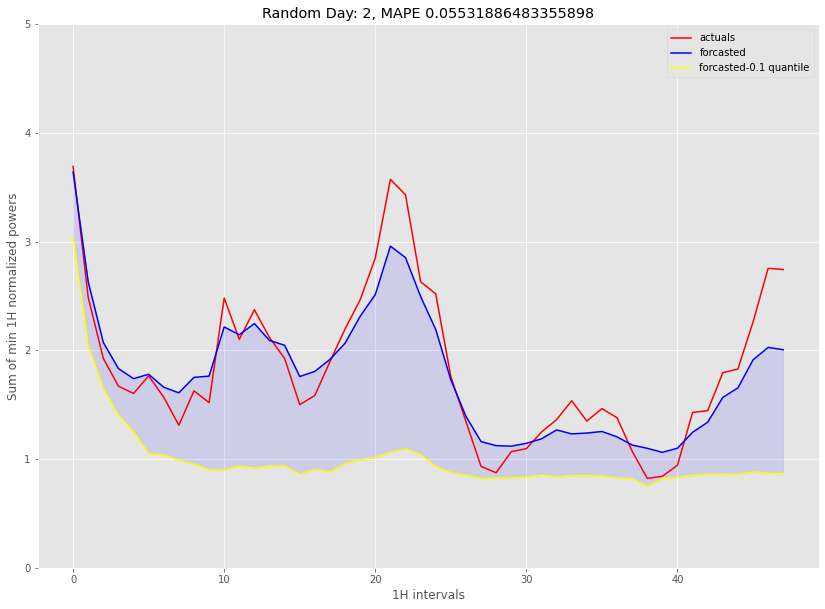

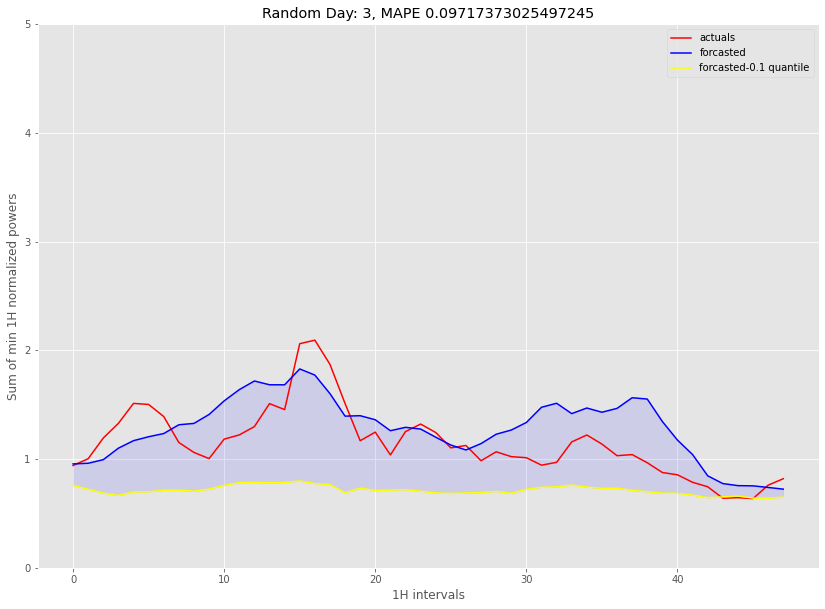

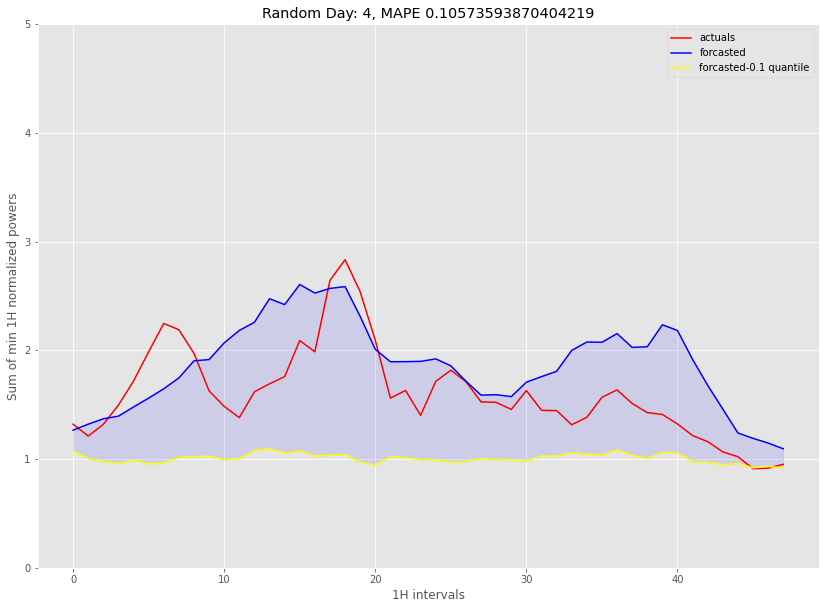

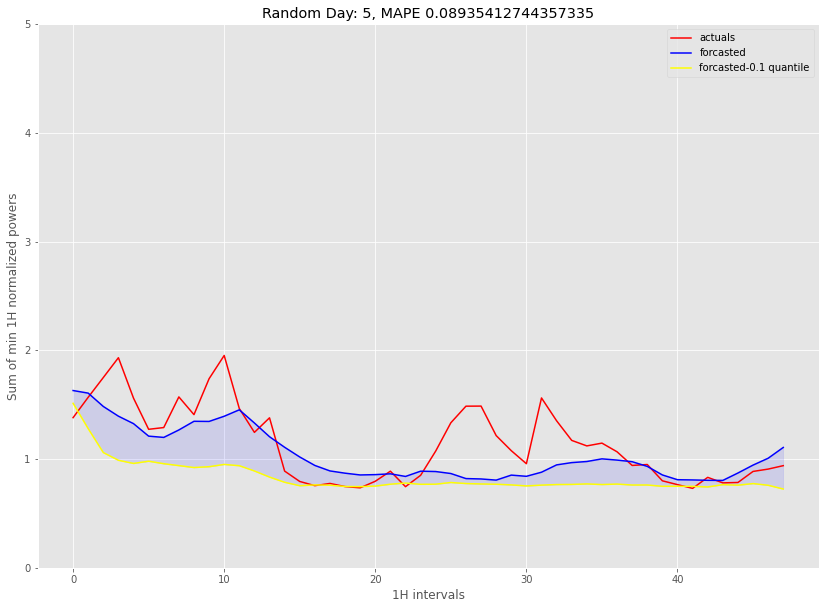

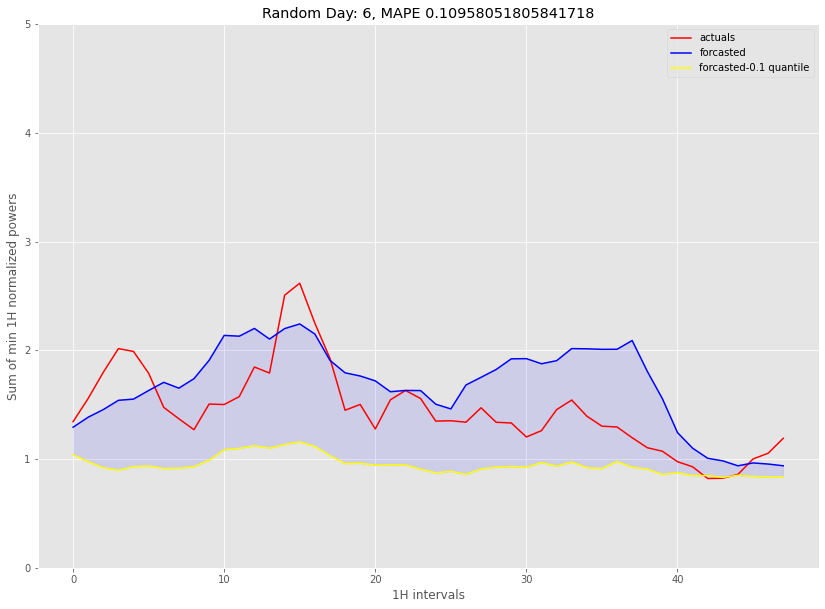

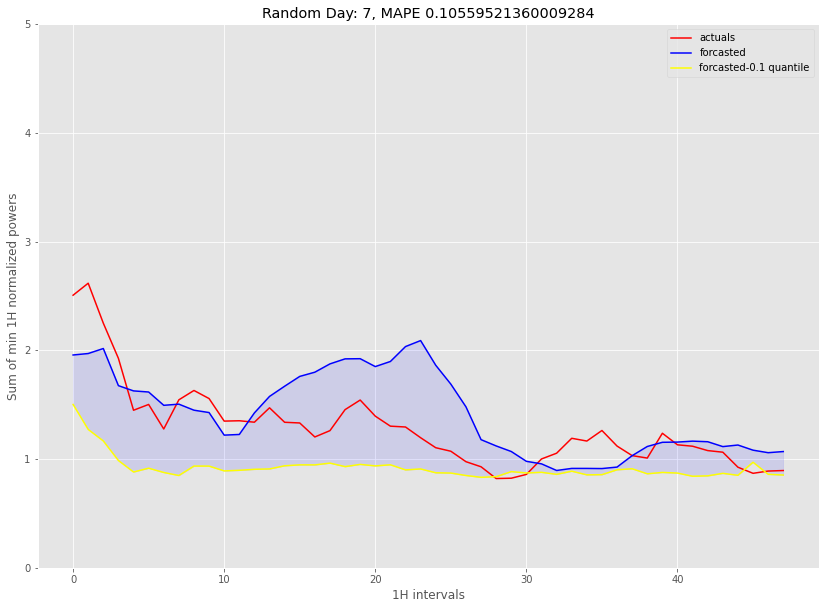

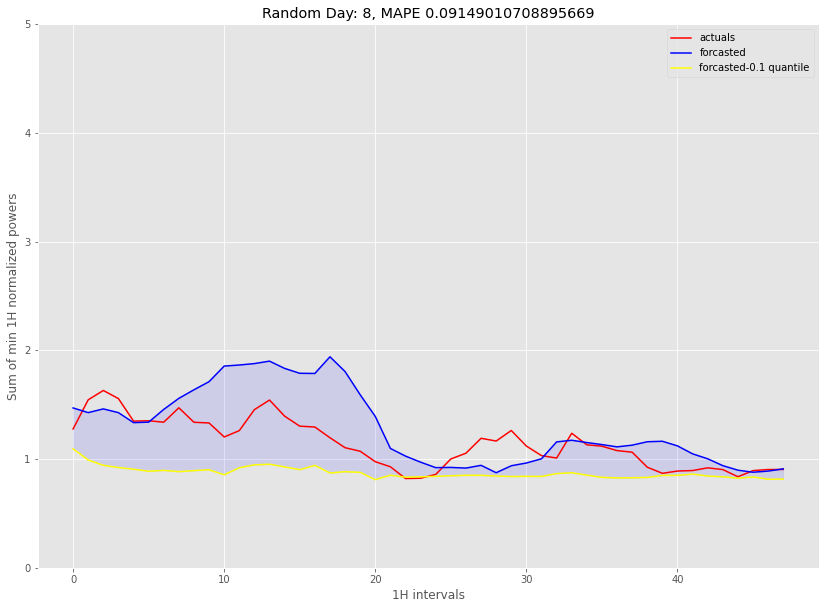

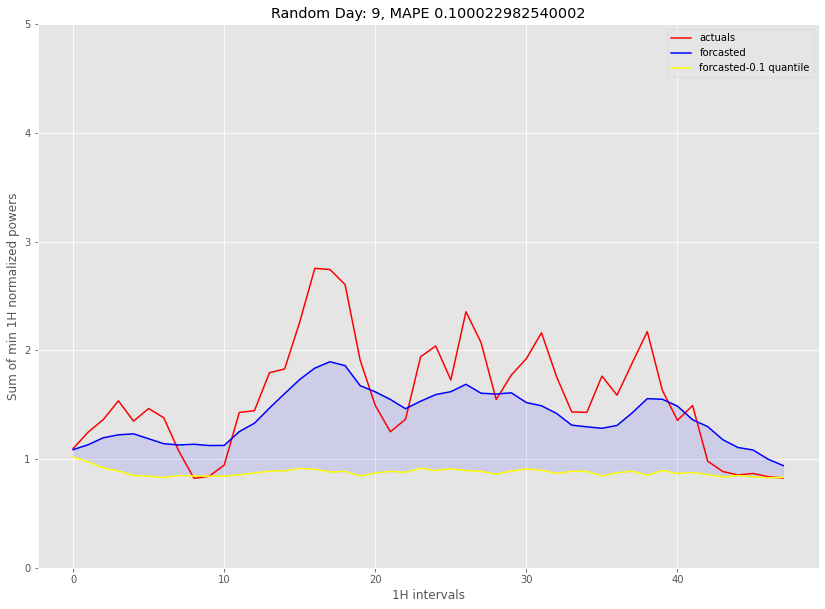

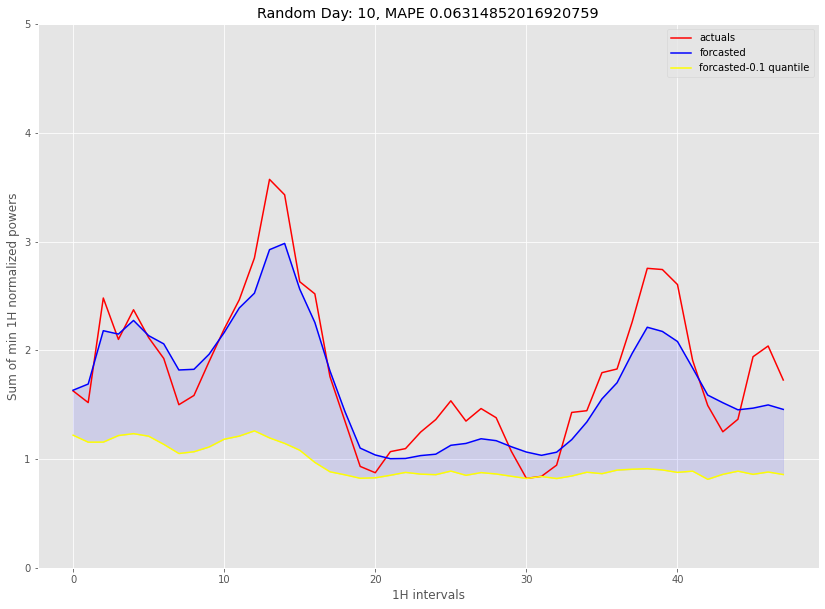

In [28]:
np.random.seed(0)
random_days = np.random.choice(np.arange(avg_test.shape[0]), 20)
print(avg_test.shape)
print(np.mean(avg_test, axis=1).shape)
random_days = np.argsort(np.mean(avg_test, axis=1))[-100:]
np.random.shuffle(random_days)
random_days = random_days[:10]

temp_arr = np.ones(len(target_features)//4) * np.nan
for d, r in enumerate(random_days):
    idx = r
    plt.figure(figsize=(14,10))
    r_mape = mape1(avg_test[idx], avg_test_preds[idx])
    plt.title(f'Random Day: {d+1}, MAPE {r_mape}')
    plt.ylabel('Sum of min 1H normalized powers')
    plt.xlabel('1H intervals')
    future = avg_test[idx]
    past = []
    actuals = np.append(past, future)
    temp_arr = np.ones(len(past)) * np.nan
    plt.plot(actuals, label = 'actuals', c='red')
    plt.plot(np.append(temp_arr, avg_test_preds[idx]), label='forcasted', c = 'blue')
    plt.plot(np.append(temp_arr, avg_test_preds_lower[idx]), label='forcasted-0.1 quantile', c='yellow')
    plt.fill_between(np.arange(avg_test_preds[idx].shape[0])+len(past), avg_test_preds_lower[idx], avg_test_preds[idx], color='blue', alpha=0.1)
    plt.ylim([0, 5])
    plt.legend()
    plt.show()